# The Battle of Neighborhoods - Applied Data Science Capstone Project  <a id="Top"></a>

## 1. Business Problem <a id="Part_1"></a>


An client is looking to open a new restaurant in Los Angeles, but he is not sure about the best location for his new venue and needs input for making the decision.So we would help to set up a new restaurant business in Los Angeles, the venue's location must be carefully picked in order to maximize the profit. 
In the capstone project, we will get the help from FourSquare API to address at least part of these considerations. 

## 2. Data <a id="Part_2"></a>


Because of the availability of datasets, we will not address all of the factors listed above. However, we will work on some of the most important factors such as visibility, parking, crime rates, and affordability. We will utilize the following datasets/tools.

Static datasets:

1. Police Crime Reports: 2010 to Present (<a href="https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq">Link</a>). The dataset includes police crime cases. 


## 3. Methodology <a id="Part_3"></a>

In this section, we are going to explore Los Angeles crime datasets and answer two of the most important factors discussed in the Introduction. Then, using the Foursquare API, we will explore neighborhoods of the city of Los Angeles. The neighborhoods will be clustered using the $k$-mean algorithm. The combined results will provide us insights into possible locations for opening a new restaurant.

In [3]:
#!conda install -c conda-forge geopandas --yes
#!conda install -c conda-forge folium --yes
#!conda install -c conda-forge geopy --yes


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pysal as ps
import requests

from pandas.io.json import json_normalize
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from sklearn.cluster import KMeans

%matplotlib inline

/srv/conda/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


### 3.1 Los Angeles Crime Data Analysis <a id="Part_3_1"></a>
<a href="#Top">Back to page top</a>

Initial check of crime data

In [5]:
df_crime = pd.read_csv("crime_2015_17.csv")
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63611 entries, 0 to 63610
Data columns (total 25 columns):
DR Number                 63611 non-null int64
Date Reported             63611 non-null object
Date Occurred             63611 non-null object
Time Occurred             63611 non-null int64
Area ID                   63611 non-null int64
Area Name                 63611 non-null object
Reporting District        63611 non-null int64
Crime Code                63611 non-null int64
Crime Code Description    63585 non-null object
MO Codes                  57206 non-null object
Victim Age                59726 non-null float64
Victim Sex                58333 non-null object
Victim Descent            58329 non-null object
Premise Code              63606 non-null float64
Premise Description       63266 non-null object
Weapon Used Code          22285 non-null float64
Weapon Description        22285 non-null object
Status Code               63611 non-null object
Status Description        636

First five rows of the dataset.

In [6]:
location_df=df_crime['Location '].str.strip('()')                               \
                   .str.split(', ', expand=True)                   \
                   .rename(columns={0:'Latitude', 1:'Longitude'}) 
df_crime=pd.concat([df_crime, location_df], axis=1)
df_crime.head()
df_crime['Latitude']=df_crime.Latitude.astype(float)
df_crime['Longitude']=df_crime.Longitude.astype(float)
df_crime.columns



Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Location ', 'Latitude', 'Longitude'],
      dtype='object')

The most important columns are Incident Category, Latitude, Longitude, and time stamps. We remove columns that are not needed for the analysis.

In [7]:
columns=['DR Number','Date Occurred', 'Time Occurred',
         'MO Codes', 'Victim Age', 'Victim Sex',
        'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4']

df_crime = df_crime.drop(columns, axis=1)

df_crime.columns

Index(['Date Reported', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'Address', 'Location ',
       'Latitude', 'Longitude'],
      dtype='object')

Dropping NaN rows from the remaining dataset.

In [8]:
df_crime.isnull().sum()

Date Reported              0
Area ID                    0
Area Name                  0
Reporting District         0
Crime Code                 0
Crime Code Description    26
Address                    0
Location                   2
Latitude                   2
Longitude                  2
dtype: int64

In [9]:
df_crime.dropna(inplace=True)
df_crime.isnull().sum()

Date Reported             0
Area ID                   0
Area Name                 0
Reporting District        0
Crime Code                0
Crime Code Description    0
Address                   0
Location                  0
Latitude                  0
Longitude                 0
dtype: int64

Get a list the type of incidents reported

In [10]:
len(df_crime['Crime Code Description'].unique())

120

Visualize crime distribution by category.

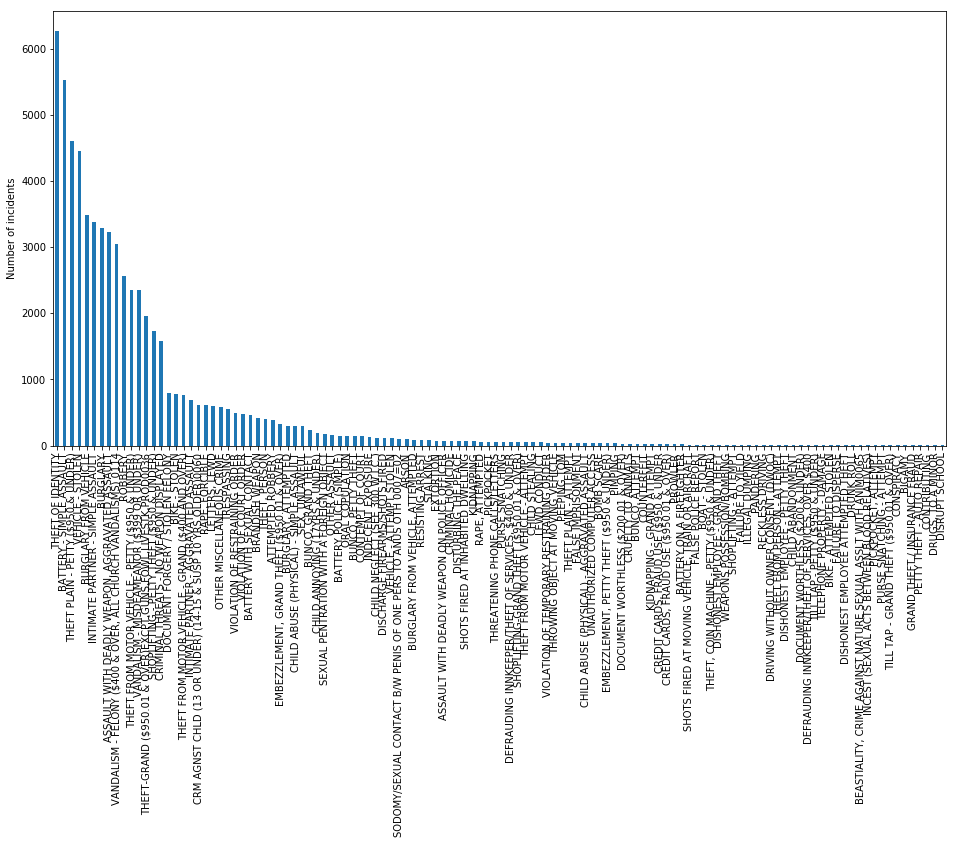

In [11]:
df_crime['Crime Code Description'].value_counts().plot(kind='bar', figsize=(16,8))
plt.ylabel('Number of incidents')
plt.show()

Visualize crime distribution by police districts.

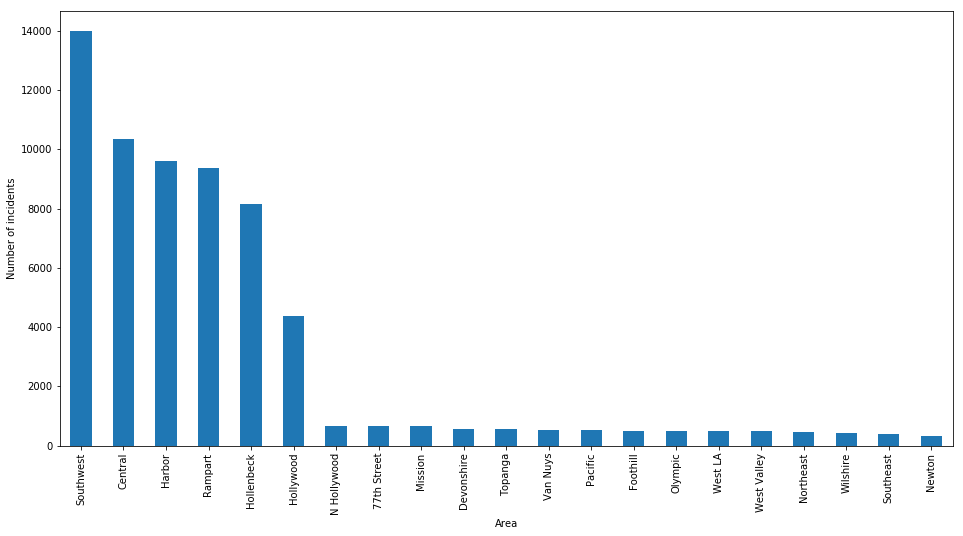

Index(['Date Reported', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'Address', 'Location ',
       'Latitude', 'Longitude'],
      dtype='object')

In [12]:
# calculating total number of crime per district
crimedata_police_district = pd.DataFrame(df_crime['Area Name'].value_counts().astype(float))
crimedata_police_district = crimedata_police_district.reset_index()
crimedata_police_district.columns = ['Area', 'Number']
crimedata_police_district.plot(kind='bar', figsize=(16,8), legend=None)
xticks = [i for i in range(len(crimedata_police_district))]
plt.xticks(xticks, list(crimedata_police_district['Area']))
plt.xlabel('Area')
plt.ylabel('Number of incidents')
plt.show()

df_crime.columns

Bureau: VALLEY BUREAU\nDistrict: 1901\nDivision: MISSION


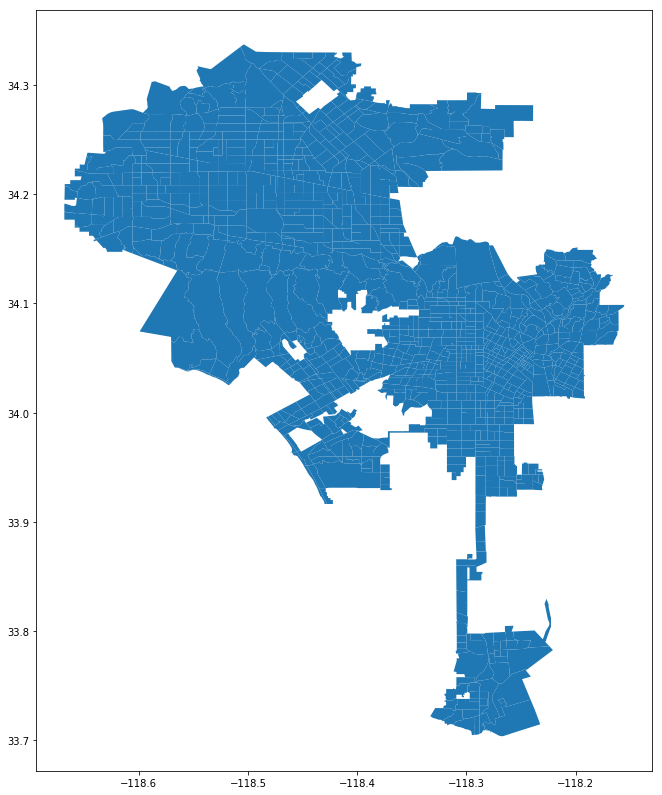

{'init': 'epsg:4326'}


In [13]:
geometry = gpd.GeoSeries(df_crime.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1), crs={'init': 'epsg:4326'})
df_crime = gpd.GeoDataFrame(df_crime, geometry=geometry)
co_data=df_crime.drop_duplicates(['Area Name'])

import geopandas as gpd
nbrhoods=gpd.read_file('LAPD_Reporting_Districts.shp')
#print(neibourhood_data.head(50))
print(nbrhoods['TOOLTIP'][0])


nbrhoods.plot(figsize=(12,14))
plt.show()

print(nbrhoods.crs)

In [14]:
nbh_crime_counts=df_crime.groupby(['Area Name']).size().reset_index(name='counts')
nbh_crime_counts['Area Name'] = nbh_crime_counts['Area Name'].str.upper()
nbh_crime_counts.head()

co_data=co_data[['Area Name','geometry']]
co_data['Area Name']=co_data['Area Name'].str.upper()
co_data.head()

nbrhoods = co_data.merge(nbh_crime_counts,on='Area Name')
nbrhoods=nbrhoods.rename(columns = {"Area Name": "nbrhood","counts":"incident_counts"}) 
nbrhoods.columns

Index(['nbrhood', 'geometry', 'incident_counts'], dtype='object')

### 3.3 Generating Crime Maps <a id="Part_3_3"></a>
<a href="#Top">Back to page top</a>

In this section, we are going to use folium to produce crime of Los Angeles we first use GeoPandas' representative_point() function to generate a representative location for each neighborhood. This data will be used to create popups on the map.

In [15]:
nbh_centroid = pd.DataFrame(nbrhoods.representative_point())
nbh_centroid.columns=(['centroid'])
nbh_centroid
nbh_centroid['nbrhood'] = nbrhoods['nbrhood']
nbh_centroid['incident_counts'] = nbrhoods['incident_counts']

In [16]:
lat = []
lng = []
for index, row in nbh_centroid.iterrows():
    tmp = str(row[0]).strip('POINT ()').split(' ')
    lng.append(float(tmp[0]))
    lat.append(float(tmp[1]))
    print(tmp[0], tmp[1])
    
nbh_centroid['Latitude'] = lat
nbh_centroid['Longitude'] = lng
nbh_centroid.head()

nbh_centroid = nbh_centroid.drop(['centroid'],axis=1)

nbh_centroid.head()



-118.2842 33.9933
-118.2954 34.0674
-118.5754 34.212
-118.2048 34.1086
-118.3768 33.9455
-118.4144 34.2066
-118.369 34.2277
-118.4263 34.1814
-118.2507 34.0481
-118.4902 34.1939
-118.2652 33.9832
-118.4895 34.2284
-118.2781 33.941
-118.4575 34.23
-118.2981 34.0813
-118.2865 34.036
-118.2174 34.0444
-118.359 34.0712
-118.3066 33.8419
-118.3044 34.0981
-118.3793 34.0594


,nbrhood,incident_counts,Latitude,Longitude
0,77TH STREET,661,33.9933,-118.2842
1,OLYMPIC,504,34.0674,-118.2954
2,TOPANGA,546,34.2120,-118.5754
3,NORTHEAST,468,34.1086,-118.2048
4,PACIFIC,511,33.9455,-118.3768


Define a function that generates popups.

In [17]:
def get_popups(df, field, name, map_object):
    for lat, lng, nbrhood, value in zip( df['Latitude'], 
                                         df['Longitude'], 
                                         df['nbrhood'], 
                                         df[field]
                                       ):
        label = ("{0}, {1}: {2:.2f}").format(nbrhood, name, value)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='green',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3).add_to(map_object)

LA_geocord = (34.052235, -118.243683)

In [18]:
# Create Los Angeles base map
LA_crime_map = folium.Map(location=LA_geocord, zoom_start=12)

#geodata = gpd.read_file('./tmp/geo_export_0e291dd6-c6fb-40dd-8323-68a750ad5743.geojson')
# Crime data at the census tract level
#threshold_scale = [0, 1000, 2000, 4000, 6000, 8000]
LA_crime_map.choropleth(geo_data        = nbrhoods.to_json(),
                        data            = nbrhoods,
                        columns         = ['nbrhood', 'incident_counts'], 
                        key_on          = 'feature.properties.nbrhood',
                        fill_color      = 'YlOrRd', 
                        fill_opacity    = 0.60, 
                        line_opacity    = 0.60,
                        legend_name     = 'Number of crimes',
                        name            = 'Number of Crimes',
                        #threshold_scale = threshold_scale,
                                  reset = True                             
                       )

get_popups(nbh_centroid, 'incident_counts', 'Incident Counts', LA_crime_map)

# Add control layer to the map
folium.LayerControl().add_to(LA_crime_map)
LA_crime_map

/srv/conda/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 3.4 Exploring Venues in Los Angeles Neighborhoods <a id="Part_3_4"></a>
<a href="#Top">Back to page top</a>

We use the Foursquare APIs to explore Los Angeles neighborhoods and cluster them using k-means clustering.

 From the previous Toronto neighbhourhood exercise, we learn that k-means will generate at least one cluster that belong's to the restaurant section. This is exactly the kind of information needed when we are looking for possible locations for opening a new restaurant.

Set up Foursqure API id and basic API call parameters

In [19]:
# @hidden_cell
CLIENT_ID = 'JBAVIGVGG3N3AWC1FGO2G3U1N3GUOWBEKXFI1SDAOCYYPULD'     
CLIENT_SECRET = 'GPGOGGAB5YFPREDIUHAT5OZNYRDBVGZH1WC21KBQMVEP3BIC' 
VERSION = '20180927'

# Set up the FourSquare API call parameters
RADIUS = 500
LIMIT  = 100

Define the function that extracts the category of the venue.

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_check_list = []
    venues_list=[]
    idx = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        num_of_venues_found = len(results)
        if (num_of_venues_found == 0):
            venues_check_list.append(False)
        else:
            venues_check_list.append(True)
        print('{0:4d} Neighborhood: {1:35s}, number of venues found:{2:6d}'.format(idx, name, num_of_venues_found))
        idx = idx + 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['nbrhood', 
                  'nbrhood Latitude', 
                  'nbrhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_check_list)


Apply the function getNearbyVenues() to the neighborhoods whose coordinates are extracted from *nbh_centroid*.

In [22]:
nbhs = nbh_centroid.loc[:, 'nbrhood']
latitudes = nbh_centroid.loc[:, 'Latitude']
longitudes = nbh_centroid.loc[:, 'Longitude']

print('\n            Search radius: {0:8.1f} meters'.format(RADIUS))
print(' Maximum number of venues: {0:6d}\n'.format(LIMIT))
LA_venues, LA_venues_check_list = getNearbyVenues(nbhs, latitudes, longitudes, RADIUS, LIMIT)

print(LA_venues.shape)
LA_venues.head()

    



            Search radius:    500.0 meters
 Maximum number of venues:    100

   0 Neighborhood: 77TH STREET                        , number of venues found:     4
   1 Neighborhood: OLYMPIC                            , number of venues found:    63
   2 Neighborhood: TOPANGA                            , number of venues found:     9
   3 Neighborhood: NORTHEAST                          , number of venues found:    11
   4 Neighborhood: PACIFIC                            , number of venues found:    24
   5 Neighborhood: N HOLLYWOOD                        , number of venues found:     2
   6 Neighborhood: FOOTHILL                           , number of venues found:    14
   7 Neighborhood: VAN NUYS                           , number of venues found:     6
   8 Neighborhood: CENTRAL                            , number of venues found:   100
   9 Neighborhood: WEST VALLEY                        , number of venues found:     6
  10 Neighborhood: NEWTON                             , numbe

,nbrhood,nbrhood Latitude,nbrhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,77TH STREET,33.9933,-118.2842,7-Eleven,33.992928,-118.282916,Convenience Store
1,77TH STREET,33.9933,-118.2842,Domino's Pizza,33.992935,-118.283025,Pizza Place
2,77TH STREET,33.9933,-118.2842,Church's Chicken,33.993423,-118.283030,Fried Chicken Joint
3,77TH STREET,33.9933,-118.2842,Restaurant Caesars,33.991934,-118.280798,Restaurant
4,OLYMPIC,34.0674,-118.2954,California Donuts,34.068965,-118.293116,Donut Shop


Find out the number of unique categories can be curated from all the returned venues.

In [23]:
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))


There are 159 uniques categories.


#### Cluster the neighborhoods using the k-means algorithm: Preprocessing
First we one-hot encode venue categories.

In [24]:
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
LA_onehot['nbrhood'] = LA_venues['nbrhood'] 

# move postcode column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.shape

(488, 160)

Group rows by neighborhood name and by taking the mean of the frequency of occurrence of each category.

In [25]:
LA_grouped = LA_onehot.groupby('nbrhood').mean().reset_index()
LA_grouped.head()

,nbrhood,Advertising Agency,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Trail,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,77TH STREET,0.0,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.0,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0
1,CENTRAL,0.0,0.010000,0.03,0.01,0.000000,0.01,0.000000,0.0,0.080000,...,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.000000,0.0,0.0
2,DEVONSHIRE,0.0,0.000000,0.00,0.00,0.083333,0.00,0.083333,0.0,0.083333,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.083333,0.0,0.0
3,FOOTHILL,0.0,0.071429,0.00,0.00,0.000000,0.00,0.000000,0.0,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0
4,HARBOR,0.0,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.0,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0


Define a function that sorts the venues in descending order.

In [26]:


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Create a dataframe that contains venues in descending order for each zipcode area.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['nbrhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
LA_venues_sorted = pd.DataFrame(columns=columns)
LA_venues_sorted['nbrhood'] = LA_grouped['nbrhood']

for ind in np.arange(LA_grouped.shape[0]):
    LA_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

print(LA_venues_sorted.shape)
LA_venues_sorted	

# Set the number of clusters
kclusters = 5

LA_grouped_clustering = LA_grouped.drop('nbrhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(LA_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



(21, 11)


array([0, 3, 0, 0, 3, 3, 4, 0, 2, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# Create the dataframe
LA_merged = LA_venues_sorted

# Add clustering labels
LA_merged['Cluster Labels'] = kmeans.labels_

# Merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
LA_merged = nbh_centroid.join(LA_venues_sorted.set_index('nbrhood'), on='nbrhood')

LA_merged.head()



,nbrhood,incident_counts,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,77TH STREET,661,33.9933,-118.2842,Pizza Place,Convenience Store,Fried Chicken Joint,Restaurant,Dumpling Restaurant,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,0
1,OLYMPIC,504,34.0674,-118.2954,Korean Restaurant,Coffee Shop,Asian Restaurant,Hotel,Thai Restaurant,Fast Food Restaurant,Dessert Shop,Sandwich Place,Bubble Tea Shop,Supermarket,3
2,TOPANGA,546,34.2120,-118.5754,South American Restaurant,Dessert Shop,Mexican Restaurant,Convenience Store,Filipino Restaurant,Fried Chicken Joint,Grocery Store,Donut Shop,Taco Place,Falafel Restaurant,0
3,NORTHEAST,468,34.1086,-118.2048,Trail,Pizza Place,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Thrift / Vintage Store,Deli / Bodega,Art Gallery,American Restaurant,Gym,0
4,PACIFIC,511,33.9455,-118.3768,Hotel,Fast Food Restaurant,Gym,Hotel Bar,Rental Car Location,Restaurant,Steakhouse,Boat or Ferry,Café,Chinese Restaurant,3


Generate the LA neighborhood clusters map.

In [28]:
# Create LA base map
LA_cluster_map = folium.Map(location=LA_geocord, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3.2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, nbrhood, cluster in zip(
                                  LA_merged['Latitude'], 
                                  LA_merged['Longitude'], 
                                  LA_merged['nbrhood'], 
                                  LA_merged['Cluster Labels']):
    label = ("Cluster : {}, Neighborhood: {}").format(cluster, nbrhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(LA_cluster_map)
    
LA_cluster_map


## 4. Results <a id="Part_4"></a>

### 4.1 Crime Maps <a id="Part_4_1"></a>
<a href="#Top">Back to page top</a>

#### Distribution of San Francisco crimes: 2018 Jan. - 2018 Sep.

In [29]:
display(LA_crime_map)

In [30]:
#display(SF_housing_map)

#### Los Angeles neighborhood clusters based on the k-means algorithm

In [31]:
display(LA_cluster_map)

---
#### The proposed location for the new restaurant
The crime and housing price maps suggest that ____ has a relatively low crime rate. This neighborhood belongs to the first cluster. Let's take a look at this cluster.

In [32]:
def examine_clusters(id):
    return LA_merged.loc[LA_merged['Cluster Labels'] == id, LA_merged.columns[[0] + [1] + list(range(5, LA_merged.shape[1]))]]

In [33]:
pd.set_option('display.max_rows', 100)
examine_clusters(0)

,nbrhood,incident_counts,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,77TH STREET,661,Convenience Store,Fried Chicken Joint,Restaurant,Dumpling Restaurant,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,0
2,TOPANGA,546,Dessert Shop,Mexican Restaurant,Convenience Store,Filipino Restaurant,Fried Chicken Joint,Grocery Store,Donut Shop,Taco Place,Falafel Restaurant,0
3,NORTHEAST,468,Pizza Place,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Thrift / Vintage Store,Deli / Bodega,Art Gallery,American Restaurant,Gym,0
6,FOOTHILL,507,Pizza Place,Grocery Store,Market,Fast Food Restaurant,Garden Center,Donut Shop,Mediterranean Restaurant,Convenience Store,Discount Store,0
9,WEST VALLEY,482,Video Store,Convenience Store,Furniture / Home Store,Gym,Golf Course,Yoga Studio,Electronics Store,Flea Market,Film Studio,0
10,NEWTON,336,Seafood Restaurant,Taco Place,Fast Food Restaurant,Burger Joint,Yoga Studio,Falafel Restaurant,Food,Flea Market,Film Studio,0
11,DEVONSHIRE,549,Wings Joint,Mexican Restaurant,Sandwich Place,Asian Restaurant,Bakery,Convenience Store,Bar,Italian Restaurant,Grocery Store,0
13,MISSION,646,Convenience Store,Food Truck,Park,Pizza Place,Pool,Home Service,Bakery,Food & Drink Shop,Flea Market,0


In [34]:
nbh_name = 'DEVONSHIRE'
nbh_index = nbrhoods.index[nbrhoods['nbrhood'] == nbh_name][0]
nbh_lat, nbh_lng = nbh_centroid.loc[nbh_index, ['Latitude', 'Longitude']]

nbrhoods.loc[nbh_index]

nbrhood                           DEVONSHIRE
geometry           POINT (-118.4895 34.2284)
incident_counts                          549
Name: 11, dtype: object

In [35]:
LA_venues_sorted.loc[LA_venues_sorted['nbrhood'] == nbh_name]

,nbrhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,DEVONSHIRE,Massage Studio,Wings Joint,Mexican Restaurant,Sandwich Place,Asian Restaurant,Bakery,Convenience Store,Bar,Italian Restaurant,Grocery Store,0


In [36]:
# Set up the FourSquare API call
section = 'food'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={0}&client_secret={1}&v={2}&ll={3},{4}&section={5}&radius={6}&limit={7}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    nbh_lat,
    nbh_lng,
    section,
    RADIUS,
    LIMIT)

# Fetch the top 100 venues
results = requests.get(url).json()

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Popeyes Louisiana Kitchen,Fried Chicken Joint,34.228569,-118.484661
1,Fratelli's Pizza,Italian Restaurant,34.228754,-118.484366
2,Wingstop,Wings Joint,34.227470,-118.485610
3,Quiznos,Sandwich Place,34.227323,-118.485599
4,Bronco Restaurant,Mexican Restaurant,34.228748,-118.485649


In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


In [39]:
# Create San Francisco base map
target_map = folium.Map(location=(nbh_lat, nbh_lng), zoom_start=17)

for lat, lng, categories in zip(
                                  nearby_venues['lat'], 
                                  nearby_venues['lng'], 
                                  nearby_venues['categories']):
    label = ("{}").format(categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(target_map)
    
target_map

In [40]:
venue_category_list = list(nearby_venues['categories'].unique())
venue_category_list

['Fried Chicken Joint',
 'Italian Restaurant',
 'Wings Joint',
 'Sandwich Place',
 'Mexican Restaurant',
 'Asian Restaurant',
 'Chinese Restaurant',
 'Donut Shop',
 'Bakery']

## Discussion <a id="Part_5"></a>
<a href="#Top">Back to page top</a>

By analyzing public datasets obtained from <a href="https://data.lacity.org/"></a>, we locate __DEVONSHIRE__ as a possible neighborhood that is ideal for opening a new restaurant. We rely on aggregating crime data, the  primary factors that are critical for determining the location.We also obtain a list of our competitors by using again the Foursquare Explore API, and are able to pinpoint the competitors' location. 
At the end, while we have identified an ideal neighborhood, we are also facing competitions. To  differenciate our new restaurant from competitors, we need inputs from the data. Obviously, our analysis has rooms for improvement.